<a href="https://colab.research.google.com/github/brendan-mccaffrey/potfolio-optimization/blob/main/main-workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Dependencies
!pip install pickle5
!pip install yfinance

import csv
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import pickle5 as pickle
import matplotlib.pyplot as plt

from numpy.linalg import inv

plt.style.use('default')
%matplotlib inline

### Extra Stuff

In [ ]:
# Extra Imports

# !pip install PyPortfolioOpt
# !pip install pandas_datareader
# !pip install scipy

# import random
# import scipy.optimize as sc

# from pypfopt import EfficientFrontier
# from pypfopt import risk_models
# from pypfopt import expected_returns
# from pandas_datareader import data as pdr

## Get CPI & PPI Data

Historical Data for US CPI & PPI were downloaded in csv files from the [St. Louis Fed](https://fred.stlouisfed.org/series/CPALTT01USM657N) website

In [38]:
# PPI
name = "US PPI Index"
ppi_df = pd.read_csv("ppi-1mo-index.csv")
ppi_df.set_index("DATE", inplace=True)
ppi_df.rename({ppi_df.columns[0]: name}, axis=1, inplace=True)

In [40]:
# CPI
name = "US CPI Index"
cpi_df = pd.read_csv("cpi-1mo-index.csv")
cpi_df.set_index("DATE", inplace=True)
cpi_df.rename({cpi_df.columns[0]: name}, axis=1, inplace=True)

In [42]:
# Combine dataframes
inf_df = pd.concat([ppi_df, cpi_df], axis=1)

In [44]:
# Drop NaNs
inf_df = inf_df.dropna()

# Converting the index as date
inf_df.index = pd.to_datetime(inf_df.index)

In [57]:
print(inf_df.head(10))

            US PPI Index  US CPI Index
DATE                                  
1960-01-01          31.6     12.391516
1960-02-01          31.6     12.408393
1960-03-01          31.8     12.408393
1960-04-01          31.8     12.463241
1960-05-01          31.7     12.475898
1960-06-01          31.7     12.492775
1960-07-01          31.7     12.467460
1960-08-01          31.6     12.492775
1960-09-01          31.6     12.492775
1960-10-01          31.7     12.551842


In [58]:
# Save asset data
with open("cpi-ppi-df.pkl", 'wb') as fp:
  pickle.dump(inf_df, fp)

## Get Asset Data

In [26]:
# Tickers
GOLD = "GLD"
WATER = "AWK"
ENERGY = "XLE"
HEALTHCARE = "XLV"
SNP = "SPY"
DJI = "DJI"
NSDQ = "^IXIC"
REAL = "IYR"
METALS = "GLTR"
TIPS = "TIP"

assets = [WATER, ENERGY, HEALTHCARE, DJI, NSDQ, SNP, REAL, METALS, TIPS, GOLD]

In [ ]:
start = True
for asset in assets:
  print("Querying asset: ", asset)
  if start:
    st = yf.download(asset, start='2004-01-01', interval='1d')
    df = st.copy()[['Close']]
    df.rename({df.columns[0]:asset}, axis=1, inplace=True)
    start = False
  else:
    df2 = yf.download(asset, start='2004-01-01', interval='1d')
    df1 = df2.copy()[['Close']]
    df1.rename({df1.columns[0]:asset}, axis=1, inplace=True)
    df = pd.concat([df,df1], axis=1)

In [ ]:
df = df.dropna()
df = df[48:]

In [ ]:
print(df.head(4))

In [ ]:
# Save asset data
with open("raw-data.pkl", 'wb') as fp:
  pickle.dump(df, fp)

## Optimize Portfolio
We will find the minimum variance portfolio, the tangency portfolio (efficient frontier x security market line), and the optimal portfolio targeting 10% return.

In [8]:
# Load data
with open("raw-data.pkl", 'rb') as fp:
  df = pickle.load(fp)

In [ ]:
print(df.head(4))

In [10]:
returns_df = df.pct_change()[1:]

In [ ]:
print(returns_df.head(4))

In [12]:
# Calculate return vector and covariance matrix
r = ((1 + returns_df).prod())**(252/len(returns_df)) - 1
cov = returns_df.cov()*252
e = np.ones(len(r))

In [15]:
# define the investable universe
icov = inv(cov)
h = np.matmul(e, icov)
g = np.matmul(r, icov)
a = np.sum(e*h)
b = np.sum(r*h)
c = np.sum(r*g)
d = a*c - b**2

In [18]:
# minimum variance and tangency portfolio
mvp = h/a
mvp_return = b/a
mvp_risk = (1/a)**(1/2)

tangency = g/b
tangency_return = c/b
tangency_risk = c**(1/2)/b

In [20]:
tangency

array([ 0.27591302, -0.1100516 ,  0.21901316,  0.05877588,  0.28491201,
        0.04375901, -0.35918672, -0.3038073 ,  0.5944021 ,  0.29627044])

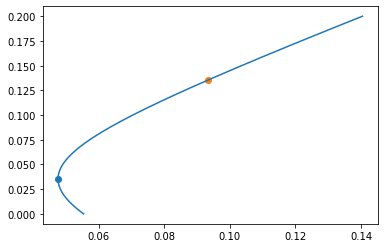

In [22]:
# plotting efficient portfolio frontier
exp_returns = np.arange(0, 0.201, 0.001)
risk = ((a*exp_returns**2 - 2*b*exp_returns + c)/d)**(1/2)
plt.plot(risk, exp_returns)
plt.scatter(mvp_risk, mvp_return)
plt.scatter(tangency_risk, tangency_return)

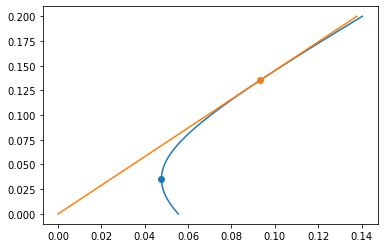

In [23]:
# Plot securities market line
sml_slope = 1/c**(1/2)
sml_risk = exp_returns*sml_slope
plt.plot(risk, exp_returns)
plt.plot(sml_risk, exp_returns)
plt.scatter(mvp_risk, mvp_return)
plt.scatter(tangency_risk, tangency_return)

In [25]:
# solving target return (set to 10%)
target_return = 0.1
if target_return < mvp_return:
  optimal_portfolio = mvp
  optimal_return = mvp_return
  optimal_risk = mvp_risk
else:
  l = (c - b*target_return)/d
  m = (a*target_return - b)/d
  optimal_portfolio = l*h + m*g
  optimal_return = np.sum(optimal_portfolio*r)
  optimal_risk = ((a*optimal_return**2 - 2*b*optimal_return + c)/d)**(1/2)

print(optimal_return, optimal_risk, optimal_portfolio)

0.10000000000000002 0.07042988092014626 [ 0.18138234 -0.08365751  0.15499179  0.04325068  0.11475723  0.16867272
 -0.26110872 -0.22840317  0.68650959  0.22360504]


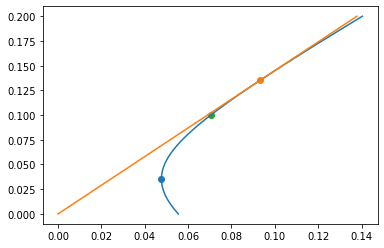

In [31]:
plt.plot(risk, exp_returns)
plt.plot(sml_risk, exp_returns)
plt.scatter(mvp_risk, mvp_return)
plt.scatter(tangency_risk, tangency_return)
plt.scatter(optimal_risk, optimal_return)

## Test Performance

In [52]:
mvp_weights = pd.DataFrame(mvp, index=assets, columns=["MVP"])
tan_weights = pd.DataFrame(tangency, index=assets, columns=["Tan"])
optimal_weights = pd.DataFrame(optimal_portfolio, index=assets, columns=["TenPct"])
portfolio_weights = pd.concat([mvp_weights, tan_weights, optimal_weights], axis=1)

In [ ]:
print(returns_df.head(4))

In [ ]:
rdf = returns_df.copy()
rdf['TenPct'] = np.ones(len(rdf))
rdf['MVP'] = np.ones(len(rdf))
rdf['Tangency'] = np.ones(len(rdf))

for x in range(len(rdf)):
  if x == 0:
    rdf['TenPct'][rdf.index[x]] = 100000.0
    rdf['MVP'][rdf.index[x]] = 100000.0
    rdf['Tangency'][rdf.index[x]] = 100000.0
    continue
  step_return_opt = 0
  step_return_mvp = 0
  step_return_tan = 0
  for ticker in assets:
    step_return_opt += rdf[ticker][rdf.index[x]] * portfolio_weights["TenPct"][ticker]
    step_return_mvp += rdf[ticker][rdf.index[x]] * portfolio_weights["MVP"][ticker]
    step_return_tan += rdf[ticker][rdf.index[x]] * portfolio_weights["Tan"][ticker]

  rdf['TenPct'][rdf.index[x]] = rdf['TenPct'][rdf.index[x-1]] * (1+step_return_opt)
  rdf['MVP'][rdf.index[x]] = rdf['MVP'][rdf.index[x-1]] * (1+step_return_mvp)
  rdf['Tangency'][rdf.index[x]] = rdf['Tangency'][rdf.index[x-1]] * (1+step_return_tan)

In [ ]:
print(rdf.head(10))

### Combine CPI & PPI with Portfolios

In [59]:
with open("cpi-ppi-df.pkl", 'rb') as fp:
  inf = pickle.load(fp)

In [ ]:
print(inf[612:])

In [72]:
inf2 = inf[612:].copy()

In [ ]:
inf2

In [87]:
inf1 = inf2.copy()

cpi_scalar = 100000.0 / inf1["US CPI Index"][0:1]
ppi_scalar = 100000.0 / inf1["US PPI Index"][0:1]

inf1["US CPI Index"] = inf1["US CPI Index"].apply(lambda x: x*cpi_scalar)
inf1["US PPI Index"] = inf1["US PPI Index"].apply(lambda x: x*ppi_scalar)

In [ ]:
inf1

In [64]:
portfolios = rdf[['TenPct', 'MVP', 'Tangency']].copy()

In [89]:
data_df = pd.concat([portfolios, inf1], join='outer', axis=1)

In [ ]:
data_df = data_df.fillna(method='ffill')

In [91]:
data_df

In [93]:
# Save Dataframe 
with open("final-df.pkl", 'wb') as fp:
    pickle.dump(data_df, fp)

## Visualize Result

In [94]:
with open("final-df.pkl", 'rb') as fp:
  df = pickle.load(fp)

Text(0, 0.5, 'Index Value (start at $100,000)')

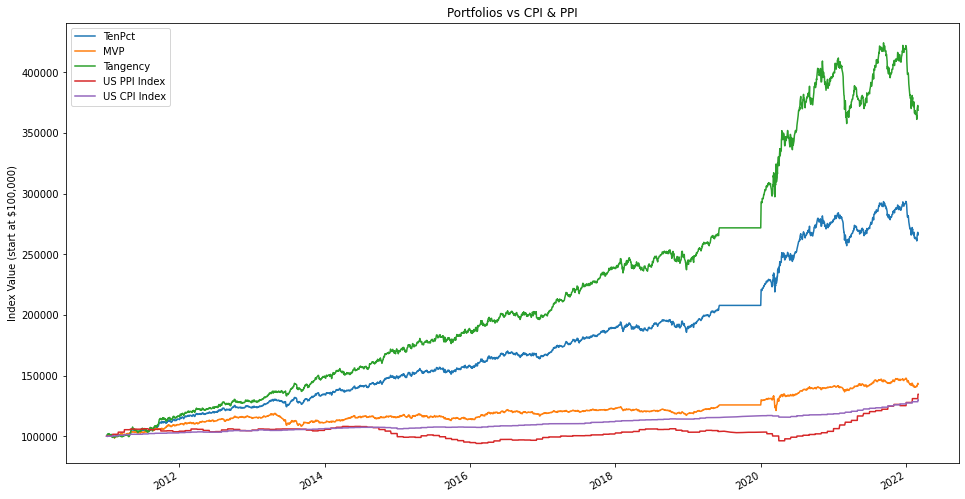

In [95]:
perf = df.plot(kind='line', figsize=(16,9), title='Portfolios vs CPI & PPI')
perf.set_ylabel("Index Value (start at $100,000)")

In [96]:
# Performance Metrics

# annualized returns and standard deviation of portfolio
def portfolio_performance(weights, meanReturns, covMatrix):
  returns = np.sum(meanReturns*weights)*252
  std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)

  return returns, std

In [97]:
opt_weights = np.array(portfolio_weights['TenPct'])
mvp_weights = np.array(portfolio_weights['MVP'])
tan_weights = np.array(portfolio_weights['Tan'])
meanReturns = returns_df.copy().mean()
covMatrix = returns_df.copy().cov()

In [101]:
print(" -- Portfolio Weights --")
display(portfolio_weights)
print()
print("Target 10% Portfolio (opt)")
returns, std = portfolio_performance(opt_weights, meanReturns, covMatrix)
print("Returns:", returns, " Annualized Std:", std)
print()
print("Tangency Portfolio")
returns, std = portfolio_performance(tan_weights, meanReturns, covMatrix)
print("Returns:", returns, " Annualized Std:", std)
print()
print("Minimum Variance Portfolio")
returns, std = portfolio_performance(mvp_weights, meanReturns, covMatrix)
print("Returns:", returns, " Annualized Std:", std)

 -- Portfolio Weights --


,MVP,Tan,TenPct
AWK,0.008307,0.275913,0.181382
XLE,-0.035333,-0.110052,-0.083658
XLV,0.037776,0.219013,0.154992
DJI,0.014826,0.058776,0.043251
^IXIC,-0.196777,0.284912,0.114757
SPY,0.397376,0.043759,0.168673
IYR,-0.081539,-0.359187,-0.261109
GLTR,-0.090347,-0.303807,-0.228403
TIP,0.855148,0.594402,0.686510
GLD,0.090563,0.296270,0.223605



Target 10% Portfolio (opt)
Returns: 0.09593833556817034  Annualized Std: 0.07042988092014621

Tangency Portfolio
Returns: 0.12917167977371988  Annualized Std: 0.09326012989989838

Minimum Variance Portfolio
Returns: 0.03509178919569238  Annualized Std: 0.04767742061933739
